In [2]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
import scipy
from skimage.filters import unsharp_mask
from natsort import natsorted
from skimage.exposure import match_histograms
# from sklearn.mixture import GaussianMixture
from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm
from skimage.metrics import normalized_root_mse as nrm
# from statsmodels.tsa.stattools import acf
import pickle
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
import time
import math
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
# from skimage.feature import SIFT, match_descriptors,plot_matches
# from skimage.feature import ORB
import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
from scipy.optimize import dual_annealing,fmin_powell
from scipy import optimize
import pickle
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
from tifffile import imread as tiffread
import sys
from util_funcs import *
import h5py

In [ ]:
path = f'scan5/'
pic_paths = os.listdir(path)
with h5py.File(path+pic_paths[0], 'r') as hf:
    original_data = np.array(hf['volume'])

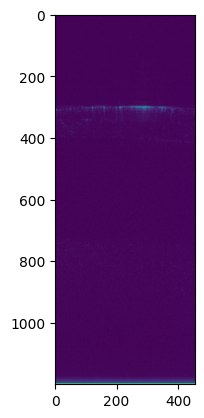

In [4]:
plt.imshow(original_data[0])

In [5]:
original_data = original_data[:,200:,:]

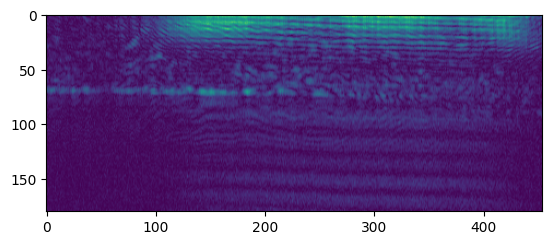

In [85]:
plt.imshow(original_data[150][120:300])

In [7]:
mid = find_mid(original_data)
n = original_data.shape[1]

# finding the bright points in all images in standard interference
nn = [np.argmax(np.sum(original_data[i][:n//2],axis=1)) for i in range(original_data.shape[0])]

# intial correcting the y-motion
tf_all_nn = np.tile(np.eye(3),(original_data.shape[0],1,1))
for i in range(tf_all_nn.shape[0]):
    tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
for i in tqdm(range(original_data.shape[0]),desc='warping'):
    original_data[i][:mid]  = warp(original_data[i][:mid],AffineTransform(matrix=tf_all_nn[i]),order=3)

# finding the bright points in all images to crop the standard interference
nn = [np.argmax(np.sum(original_data[i][:n//2],axis=1)) for i in range(original_data.shape[0])]
UP, DOWN = np.min(nn)-80,np.max(nn)+80
UP = UP if UP>0 else 0
DOWN = DOWN if DOWN<original_data.shape[1] else original_data.shape[1]

print(UP,DOWN)

warping: 100%|██████████| 500/500 [00:06<00:00, 78.15it/s]


22 182


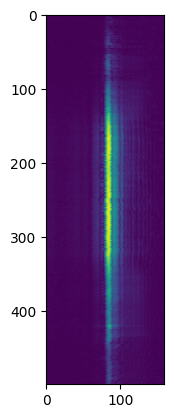

In [8]:
plt.imshow(original_data[:,UP:DOWN,:][:,:,400])

In [9]:
# better correcting the y-motion using functions
tr_all = ants_all_trans(original_data,UP,DOWN) # fucntion definition in util_funcs.py
for i in tqdm(range(original_data.shape[0]),desc='warping'):
    original_data[i][:mid]  = warp(original_data[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)



warping: 100%|██████████| 500/500 [00:06<00:00, 76.38it/s]


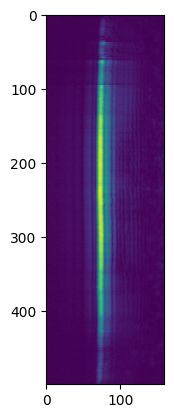

In [84]:
plt.imshow(original_data[:,UP:DOWN,:][:,:,200])

In [175]:
temp_img = original_data[:,UP:DOWN,:][:,95,:][:,150:350].copy()

# tp = fft2(temp_img).flatten()
# tp[tp.shape[0]//2:] = 0
# # tp = np.where(np.abs(tp)>7.7,tp,0)
# temp_img = ifft2(tp.reshape(temp_img.shape)).real

In [176]:
# with open('shift_IRcard.pickle', 'rb') as file:
#     sf1 = pickle.load(file)

# with open('shift_IRcard2.pickle', 'rb') as file:
#     sf2 = pickle.load(file)

# for i in range(1,sf1.shape[0]):
#     sf1[i] += sf1[i-1]

# for i in range(1,sf2.shape[0]):
#     sf2[i] += sf2[i-1]

In [177]:
# for i in tqdm(range(len(sf2))):
#     temp_img[i] = scp.shift(temp_img[i],shift = (sf2[i]),order=3,mode='nearest')

In [178]:
from skimage.filters import median as mf

In [179]:
def shift_func(shif, x, y , past_shift):
    x = scp.shift(x, -past_shift,order=3,mode='nearest')
    y = scp.shift(y, past_shift,order=3,mode='nearest')

    warped_x_stat = scp.shift(x, -shif[0],order=3,mode='nearest')
    warped_y_mov = scp.shift(y, shif[0],order=3,mode='nearest')

    return (1-ncc1d(warped_x_stat ,warped_y_mov))
# def denoise_signal(errs , rows = 10):
#     kk = fft(errs)
#     kk[rows:] = 0
#     kk = abs(ifft(kk))
#     return kk

In [180]:
# filtered_img = mf(temp_img)

In [181]:
sf = [0]
for i in tqdm(range(temp_img.shape[0]-1)):
        # st = temp_img[i]
        # mv = temp_img[i+1]
        # mv = filtered_img[i]
        grad_feat = np.argmax(np.abs(np.gradient(temp_img[i])[5:-5]))+5
        # print(grad_feat,i)
        grad_feat = max(20,grad_feat)
        grad_feat = min(grad_feat,temp_img.shape[1]-20)

        st = temp_img[i][grad_feat-20:grad_feat+20]
        mv = temp_img[i+1][grad_feat-20:grad_feat+20]

        rt = 0
        past_shift = 0
        for _ in range(5):
                # move = minz(method='powell',fun = shift_func,x0 =(0),bounds = ([(-3,3)]),
                #         args = (st
                #                 ,mv
                #                 ,past_shift))['x']

                move = minz(method='L-BFGS-B',fun = shift_func,x0 =(0),bounds = ([(-3,3)]),
                        args = (min_max(st)
                                ,min_max(mv)
                                ,past_shift))['x']

                past_shift += move[0]
                rt+=move[0]
        sf.append(rt*2)

100%|██████████| 499/499 [00:05<00:00, 94.80it/s] 


In [183]:
sf = np.array(sf)
# for i in range(0,sf.shape[0]):
#     sf[i] += sf[i-1]

for i in tqdm(range(1,len(sf),2)):
    temp_img[i] = scp.shift(temp_img[i],shift = sf[i],order=3,mode='nearest')

100%|██████████| 250/250 [00:00<00:00, 12352.46it/s]


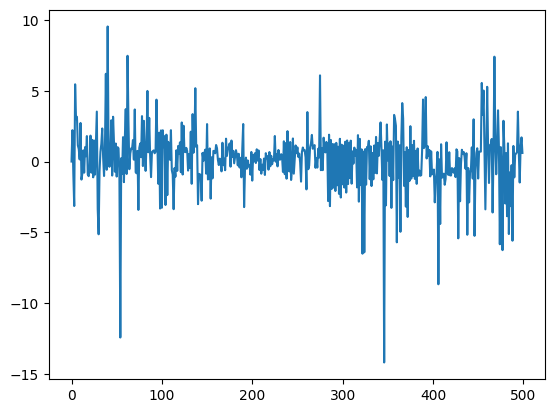

In [184]:
plt.plot(sf)

In [163]:
# temp_img = original_data[:,UP:DOWN,:][:,95,:].copy()
# for i in range(len(sf)):
#     temp_img[i] = scp.shift(temp_img[i],sf[i],mode='nearest',order=3)

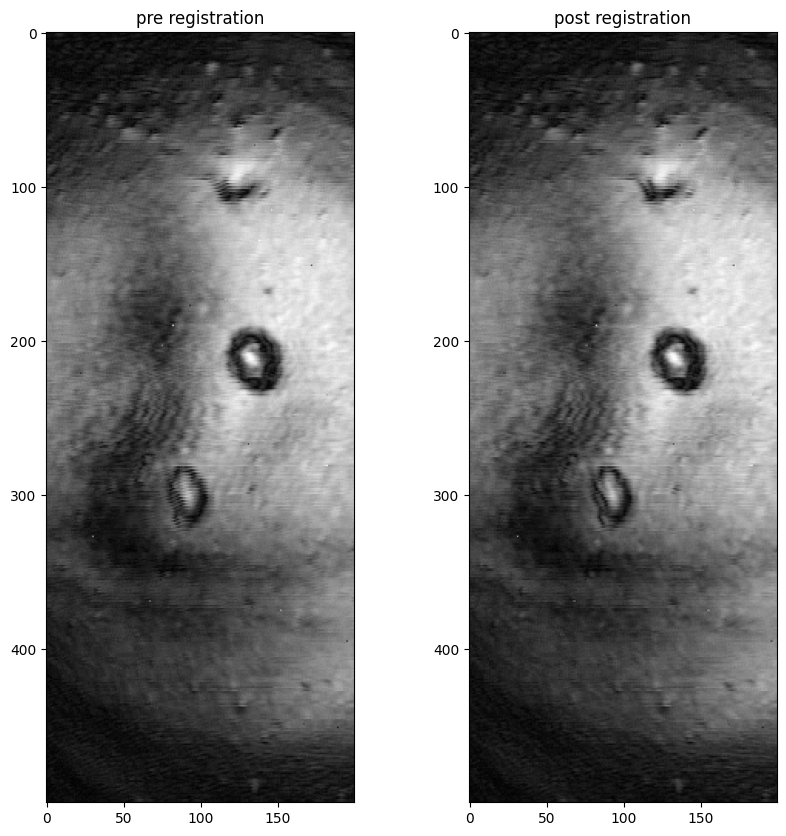

In [185]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('pre registration')
plt.imshow(original_data[:,UP:DOWN,:][:,95,150:350],cmap='gray')

plt.subplot(1,2,2)
plt.title('post registration')
plt.imshow(temp_img,cmap='gray')

In [186]:
# temp_img = original_data[:,UP:DOWN,:][:,95,:].copy()
# for i in range(len(kk)):
#     temp_img[i+1] = scp.shift(temp_img[i+1],kk[i])

gg = original_data.copy()
for i in tqdm(range(1,original_data.shape[0],2)):
    gg[i] = scp.shift(gg[i],shift = (0,sf[i]),order=3)
# for i in range(len(kk)):
#     original_data[i+1] = scp.shift(original_data[i+1],shift = (0,kk[i][0]),order=3)

100%|██████████| 250/250 [00:11<00:00, 22.37it/s]


In [187]:
os.makedirs('test',exist_ok=True)
for i,j in tqdm(enumerate(original_data)):
    cv2.imwrite(f'test/'+f'frame_test{i}.PNG',j)

500it [00:01, 254.91it/s]
